# Spectrum calculation

This section currently focus on the calculation of absorption spectra, with fluorescence and vibrational effects to added.

In [1]:
import copy

import adcc
import gator
import matplotlib.pyplot as plt
import multipsi as mtp
import numpy as np
import veloxchem as vlx
from matplotlib import gridspec
from scipy.interpolate import interp1d
from veloxchem.lreigensolver import LinearResponseEigenSolver
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI

comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386


def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy, end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = yi[i] + y[k] * (gamma / 2.0) / (
                (xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2
            )
    return xi, yi

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


## Absorption spectra

(sec:adc-spectra)=
### Spectra from ADC eigenstates

The first six excited states of water is calculated as:

In [2]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Construct structure and basis objects
struct = gator.get_molecule(water_xyz)
basis = gator.get_molecular_basis(struct, "6-31G")

# Perform SCF calculation
scf_gs = gator.run_scf(struct, basis)

# Calculate the 6 lowest eigenstates
adc_res = gator.run_adc(struct, basis, scf_gs, method="adc3", singlets=6)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
         

The resuls can be printed as a table, and convoluted and plotted using built-in functionalities (which can use several different energy-axis, as shown below).

+--------------------------------------------------------------+
| adc3 (adc2)                             singlet ,  converged |
+--------------------------------------------------------------+
|  #        excitation energy     osc str    |v1|^2    |v2|^2  |
|          (au)           (eV)                                 |
|  0     0.3127134      8.509364   0.0134     0.951   0.04895  |
|  1     0.3933877      10.70463   0.0000    0.9532   0.04681  |
|  2     0.4056694      11.03883   0.1161    0.9491   0.05091  |
|  3     0.4916579      13.37869   0.1103     0.949   0.05096  |
|  4     0.5655096       15.3883   0.4351    0.9625   0.03751  |
|  5     0.6977152       18.9858   0.2604    0.9537   0.04626  |
+--------------------------------------------------------------+



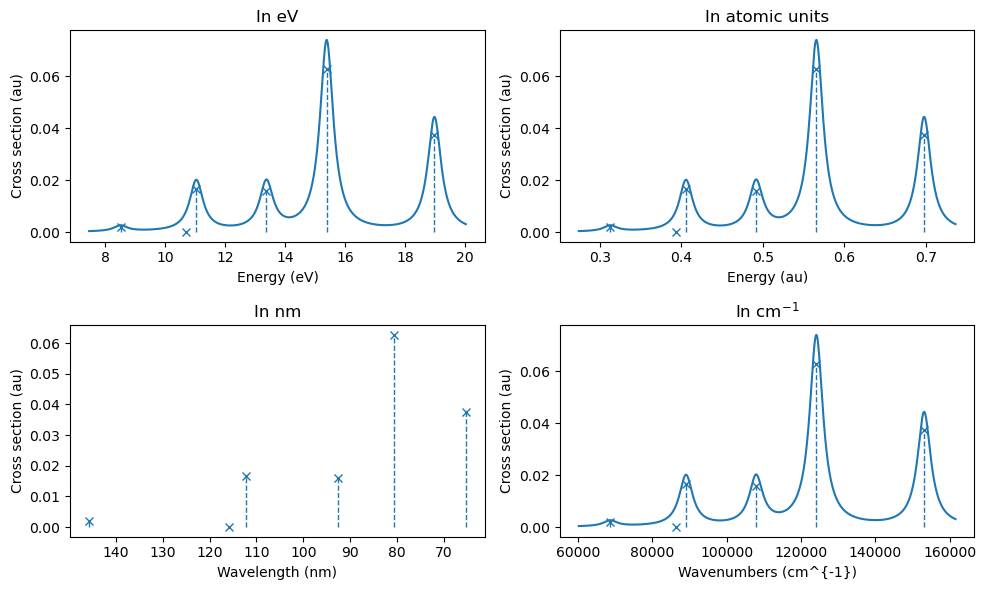

In [3]:
# Print information on eigenstates
print(adc_res.describe())

# Plot using built-in functionalities
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.title("In eV")
adc_res.plot_spectrum(xaxis="eV")
plt.subplot(222)
plt.title("In atomic units")
adc_res.plot_spectrum(xaxis="au")
plt.subplot(223)
plt.title("In nm")
adc_res.plot_spectrum(xaxis="nm", broadening=None)
plt.subplot(224)
plt.title(r"In cm$^{-1}$")
adc_res.plot_spectrum(xaxis="cm-1")
plt.tight_layout()
plt.show()

*Note that the* nm *selection (which is the inverse of the energy) is here not broadened.*

The built-in functionality uses a small default broadening and plots the full region which is resolved, while we might want to focus on lower-energy and larger broadenings, as can be done with manual routines:

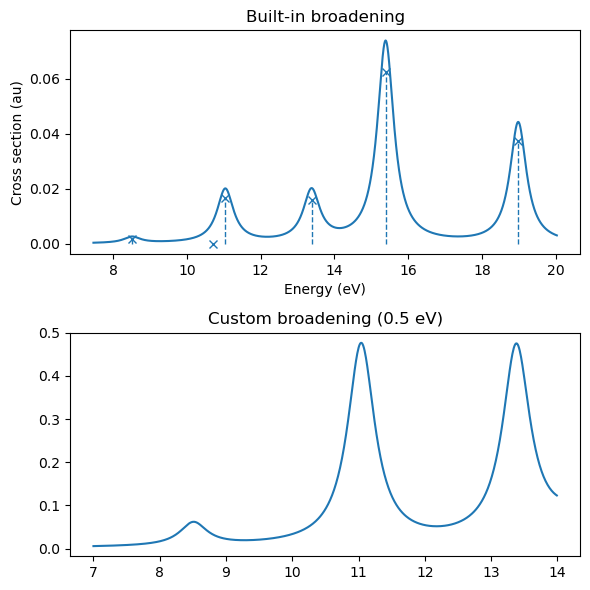

In [4]:
plt.figure(figsize=(6, 6))
# Convolute using functionalities available in gator and adcc
plt.subplot(211)
plt.title("Built-in broadening")
adc_res.plot_spectrum()

# Convoluted using information on excitation energies and oscillator strengths
plt.subplot(212)
plt.title("Custom broadening (0.5 eV)")
x, y = au2ev * adc_res.excitation_energy, adc_res.oscillator_strength
xi, yi = lorentzian(x, y, 7, 14, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

Note that some high-energy features can be the result of a discretized continuum region. A larger basis set will flatten out this region, but care should be taken for any analysis of that part of the spectrum.

### Spectra from CPP-ADC

```{note}
To be added.
```

### Spectra from TDDFT eigenstates

Calculating the first six eigenstates using TDDFT:

In [5]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver(comm, ostream=silent_ostream)
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_drv.compute(molecule, basis)

# resolve four eigenstates
rpa_solver = LinearResponseEigenSolver(comm, ostream=silent_ostream)
rpa_solver.update_settings({"nstates": 6}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_drv.scf_tensors)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
         

There are currently no built-in functionalities for obtaining the broadened spectra, so we instead construct this from the eigenvalues and oscillator strengths, as well as printing a table with energies (here in atomic units), oscillator strengths, and transition dipole moments:

Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)
   0.286      0.01128   0.00000   0.24321   0.00000
   0.364      0.09652  -0.00000  -0.00000   0.63080
   0.364      0.00000   0.00000   0.00000  -0.00000
   0.454      0.08684  -0.53570   0.00000  -0.00000
   0.540      0.41655  -1.07524   0.00000   0.00000
   0.666      0.24377  -0.00000  -0.00000  -0.74073


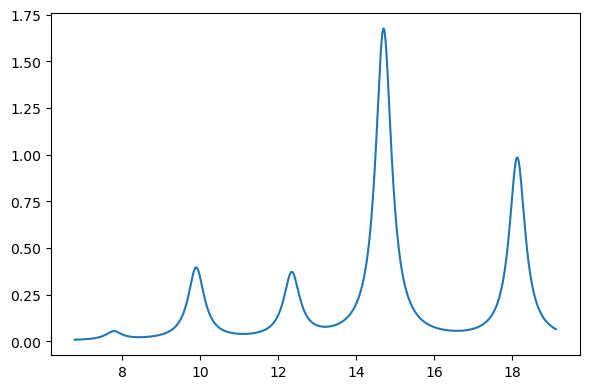

In [6]:
# Print results as a table
print("Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)")
for i in np.arange(len(rpa_results["eigenvalues"])):
    e, os, x, y, z = (
        rpa_results["eigenvalues"][i],
        rpa_results["oscillator_strengths"][i],
        rpa_results["electric_transition_dipoles"][i][0],
        rpa_results["electric_transition_dipoles"][i][1],
        rpa_results["electric_transition_dipoles"][i][2],
    )
    print("   {:.3f}     {:8.5f}  {:8.5f}  {:8.5f}  {:8.5f}".format(e, os, x, y, z))
    
plt.figure(figsize=(6, 4))
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

The resulting spectra agrees well with ADC(3), with a difference in absolute energies of about 0.7 eV:

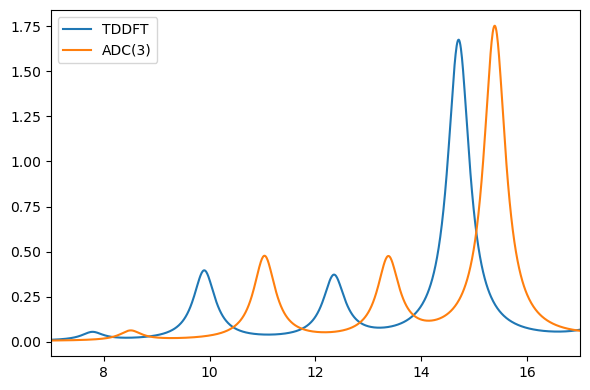

In [7]:
plt.figure(figsize=(6, 4))
xmin,xmax = 7,17
x = au2ev * rpa_results["eigenvalues"]
y = rpa_results["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)
x, y = au2ev * adc_res.excitation_energy, adc_res.oscillator_strength
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("TDDFT", "ADC(3)"))
plt.xlim((xmin,xmax))
plt.tight_layout()
plt.show()

### Spectra from CPP-DFT

Using CPP-DFT, the linear absorption cross-section is resolved over a range of energies, which is here chosen as the 7-17 eV (with a resolution of 0.1 eV):

In [8]:
# Define spectrum region to be resolved
freqs = np.arange(7.0, 17.0, 0.1) / au2ev
freqs_str = [str(x) for x in freqs]

# Calculate the response
cpp_prop = LinearAbsorptionCrossSection(
    {"frequencies": ",".join(freqs_str), "damping": 0.3 / au2ev}, method_settings
)
cpp_prop.init_driver(comm, ostream=silent_ostream)
cpp_prop.compute(molecule, basis, scf_drv.scf_tensors)

# Extract the imaginary part of the complex response function and convert to absorption cross section
sigma = []
for w in freqs:
    axx = -cpp_prop.rsp_property["response_functions"][("x", "x", w)].imag
    ayy = -cpp_prop.rsp_property["response_functions"][("y", "y", w)].imag
    azz = -cpp_prop.rsp_property["response_functions"][("z", "z", w)].imag
    alpha_bar = (axx + ayy + azz) / 3.0
    sigma.append(4.0 * np.pi * w * alpha_bar / 137.035999)

Plotting the raw output, the raw output with a splined function, and a comparison to the eigenstate results above (here plotted as bars):

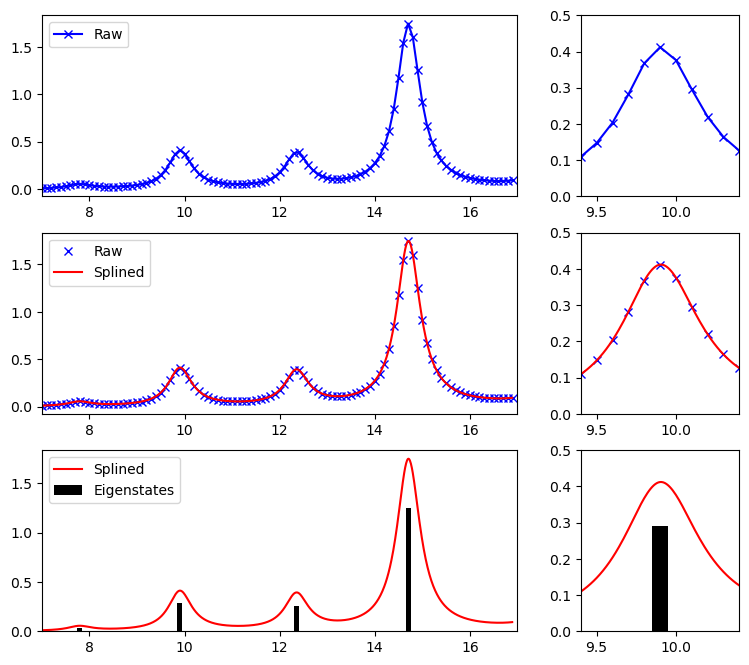

In [9]:
# Make figure with panels of 3:1 width
plt.figure(figsize=(9, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[3, 1])

# Raw results for the full region
plt.subplot(gs[0])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.legend(("Raw", ""),loc='upper left')
plt.xlim((xmin,xmax))

# Raw results for a zoomed in region
plt.subplot(gs[1])
plt.plot(au2ev * freqs, sigma, "bx-")
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

# Raw and splined spectra for the full region
plt.subplot(gs[2])
plt.plot(au2ev * freqs, sigma, "bx")
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
plt.legend(("Raw", "Splined"),loc='upper left')
plt.xlim((xmin,xmax))

# Zoomed in raw and splined spectra
plt.subplot(gs[3])
plt.plot(au2ev * freqs, sigma, "bx")
plt.plot(x, y(x), "r")
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

# Zoomed in raw and splined spectra for the full region
plt.subplot(gs[4])
x = np.arange(min(au2ev * freqs), max(au2ev * freqs), 0.01)
y = interp1d(au2ev * freqs, sigma, kind="cubic")
plt.plot(x, y(x), "r")
xi = au2ev * rpa_results["eigenvalues"]
yi = rpa_results["oscillator_strengths"]
plt.bar(xi, 3.0*yi,width=0.1, color='k')
plt.legend(("Splined", "Eigenstates"),loc='upper left')
plt.xlim((xmin,xmax))

# Zoomed in raw and splined spectra
plt.subplot(gs[5])
plt.plot(x, y(x), "r")
plt.bar(xi, 3.0*yi,width=0.1, color='k')
plt.xlim((9.4, 10.4))
plt.ylim((0, 0.50))

plt.show()

### Spectra from MCSCF

In some cases, it can be preferable to use a multiconfigurational wavefunction to compute excitation energies. This is necessary if, for instance, the molecule is suspected to have strong correlation effects, or if the user is interested in analyzing a conical intersection --- something that ADC and TDDFT often fail to properly describe.

In principle, a MCSCF spectrum can be computed using response theory similarly to ADC and DFT. However, as configuration interaction (CI) can naturally provide not just the lowest but any state, it is possible to produce excited states by simply increasing the number of requested states or "roots" in the CI. However, in traditional MCSCF, the orbitals cannot be simultaneously optimized for each state, and instead we use a set of orbitals that is a compromise between all states: the state-averaged orbitals.

For water in its equilibrium distance, there is no strong correlation, and thus the only orbitals we need to include in the active space are those that can be excited in the UV-visible spectrum. Here, we will use a CASSCF with an active space comprising the molecular orbitals formed by the oxygen 2p and hydrogen 1s, corresponding to the two $\sigma$ and $\sigma^*$ and one oxygen lone pair. We could in principle include the other lone pair, formed mostly by the 2s orbital of the oxygen, but its orbital energy is much lower and the orbital is thus not involved in the lowest UV-visible transitions.

The orbitals are conveniently located around the HOMO-LUMO gap, so it is sufficient to request a CAS(6,5) (6 electrons in 5 orbitals) to get the desired active space. First, we calculate the SCF ground state:

In [10]:
# Prepare molecule and basis objects
molecule = vlx.Molecule.read_str(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

# SCF calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.9/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                                  Basis: 6-31G                                                                            
                                                                                                                          
                                  Atom Contracted GTOs          Primitive GTOs                                            
                                                                                                                          
         

{'S': array([[ 1.        ,  0.23368986,  0.16727976,  0.03446908,  0.06872281,
          0.03446908,  0.06872281,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.23368986,  1.        ,  0.76364081,  0.24635401,  0.37904536,
          0.24635401,  0.37904536,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.16727976,  0.76364081,  1.        ,  0.4254384 ,  0.68219684,
          0.4254384 ,  0.68219684,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.03446908,  0.24635401,  0.4254384 ,  1.        ,  0.65829197,
          0.05097439,  0.22309719,  0.        ,  0.        , -0.1749796 ,
         -0.35743592, -0.22558965, -0.46081854],
        [ 0.06872281,  0.37904536,  0.68219684,  0.65829197,  1.        ,
          0.22309719,  0.51449213,  0.        ,  0.        , -0.09059884,
         -0.29517246, -0.1168031 , -0.38054637],
        [ 

Then we resolve the six lowest excited states:

In [11]:
# Active space settings
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)
space.CAS(6, 5)  # 3 O_2p and 2 H_1s

# CASSCF calculation
mcscf_drv = mtp.McscfDriver()
mcscf_drv.compute(molecule, basis, space, 6)  # 6 states

# Transition properties
SI = mtp.InterState()
DipOsc = SI.diposc(molecule, basis, mcscf_drv.CIVecs)


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 2
Number of active orbitals:              5
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(6,5)

          CI expansion:
          -------------
Number of determinants:      55


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.617648941     0.0e+00      4.8e-01          1   0:00:00
        2     -75.642903350    -2.5e-02      1.7e-01          1   0:00:00
        3     -75.646125925    -3.2e-03      1.9e-02          1   0:00:00
        4

The resulting states are printed above, or can be printed or plotted:

Energy [au]  Osc. str.
   0.279      0.01220
   0.362      0.00000
   0.381      0.10978
   0.463      0.15455
   0.535      0.59936


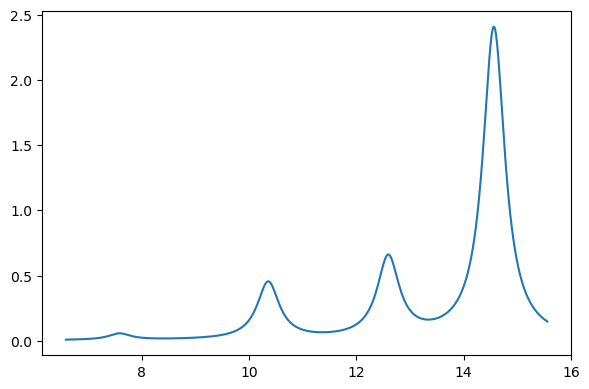

In [12]:
# Print results as a table
print("Energy [au]  Osc. str.")
for i in np.arange(len(DipOsc["energies"])):
    e, os = (
        DipOsc["energies"][i],
        DipOsc["oscillator_strengths"][i],
    )
    print("   {:.3f}     {:8.5f}".format(e, os))
    
plt.figure(figsize=(6, 4))
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, min(x) - 1.0, max(x) + 1.0, 0.01, 0.5)
plt.plot(xi, yi)
plt.tight_layout()
plt.show()

Comparing to ADC(3) we see a good agreement in relative features, but the absolute energies and intensities are a bit different:

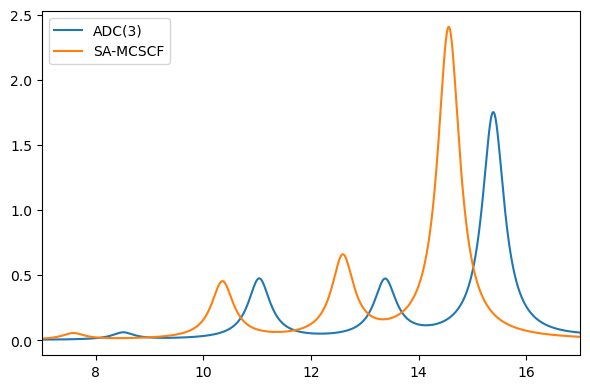

In [13]:
plt.figure(figsize=(6, 4))
xmin,xmax = 7,17

# ADC(3)
x, y = au2ev * adc_res.excitation_energy, adc_res.oscillator_strength
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)

# SA-MCSCF
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)
plt.legend(("ADC(3)","SA-MCSCF"))
plt.xlim((xmin,xmax))
plt.tight_layout()
plt.show()

As an alternative to using state-averaging, we can also use linear response CASSCF. One advantage in this case is that we do not need to add the oxygen lone pair in the active space, since the response includes also excitation outside of the active space. Let's try it:

In [14]:
# Active space settings
space = mtp.OrbSpace(molecule, scf_drv.mol_orbs)

# The list of active orbitals, orbital 4 is not here since it is the lone pair
space.CASOrb([2,3,5,6])

# CASSCF calculation
mcscf_drv = mtp.McscfDriver()
mcscf_drv.compute(molecule, basis, space)  # Only ground state

# Response calculation
mcrpa = mtp.Mclr_EigenSolver()
rspdict = mcrpa.compute(molecule,basis,mcscf_drv,5) 


          Active space definition:
          ------------------------
Number of inactive (occupied) orbitals: 3
Number of active orbitals:              4
Number of virtual orbitals:             6

    This is a CASSCF wavefunction: CAS(4,4)

          CI expansion:
          -------------
Number of determinants:      21


                                                                                                                          
        MCSCF Iterations
        ----------------
                                                                                                                          
     Iter. | Average Energy | E. Change | Grad. Norm | CI Iter. |   Time
     ---------------------------------------------------------------------
        1     -75.991165249     0.0e+00      3.9e-02          1   0:00:00
        2     -76.005855741    -1.5e-02      6.6e-02          1   0:00:00
        3     -76.031621117    -2.6e-02      3.4e-02          1   0:00:00
        4

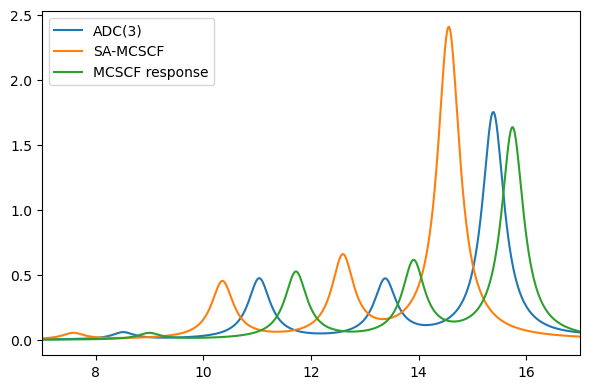

In [15]:
plt.figure(figsize=(6, 4))
xmin,xmax = 7,17

# ADC(3)
x, y = au2ev * adc_res.excitation_energy, adc_res.oscillator_strength
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)

# SA-MCSCF
x = au2ev * DipOsc["energies"]
y = DipOsc["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)
plt.plot(xi, yi)

# MCSCF response
x = au2ev * rspdict["eigenvalues"]
y = rspdict["oscillator_strengths"]
xi, yi = lorentzian(x, y, xmin,xmax, 0.01, 0.5)

plt.plot(xi, yi)
plt.legend(("ADC(3)", "SA-MCSCF", "MCSCF response"))
plt.xlim((xmin,xmax))
plt.tight_layout()
plt.show()

## Emission

```{note}
To be added.
- Coumarin example
```


## Vibrations

```{note}
To be added.
```